# Projeto Inadimplência - Parte 2

Na parte 1 do nosso projeto, preparamos os dados em um banco de dados SQL (SQL Server). Aqui, vamos continuar, dando o devido tratamento a informações contidas nesse banco de dados.

Vamos fazer uma análise em <i><b>Python</b></i> dos dados para obter insights, fazendo uma pequena <i><b>análise exploratória</b></i> dos dados.

In [70]:
##

<span style="font-size: 18px;">Parte 2.1 - Importação de módulos e Conexão com nosso banco.</span>

In [71]:
#Baixando bibliotecas para estabelecer conexões com o banco de dados SQL
#!pip install pymssql

In [72]:
#Adicionando as bibliotecas que iremos utilizar. (Também poderiámos ter feito !pip freeze > requirements.txt)
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo
import pymssql as sql #conexão SQL

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.options.display.float_format = '{:.2f}'.format

O pacote warnings é usado para ignorar avisos. Eu coloquei warnings.filterwarnings("ignore", category=UserWarning) para específicar o aviso e deixar mais seguro.

O pd.set_option pode ser removido de ambientes de produção para se evitar sobrecarga de memória.

O LabelEncoder será útil para lidar com variáveis categóricas no futuro.

In [73]:
#Vamos gerar uma conexão com o banco de dados, já evitando erros de conexão em caso de falhas inesperadas.
try:
    # Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
    conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')
    # Chama a consulta ao banco de dados passando os parametros da conexão criada
    df_original = pd.read_sql_query('SELECT * FROM EXTRACAO_DADOS_SISTEMA', conexao)
except Exception as e:
    print(f"Erro ao conectar ao banco de dados: {e}")
finally:
    # Fecha conexão com banco de dados
    conexao.close()


<span style="font-size: 18px;">Parte 2.2 - Análise Exploratória.</span>

O objetivo desta análise exploratória é fornecer uma visão geral do conjunto de dados, destacando aspectos essenciais como seu tamanho, as variáveis presentes, os tipos de dados e o período abrangido pelas informações.

Esse processo inicial permitirá entender melhor a estrutura dos dados, identificar padrões, lacunas e possíveis outliers, além de fornecer uma base sólida para as etapas subsequentes da análise.

In [74]:
#Tamanho do conjunto de dados. 
df_original.shape

(10415, 20)

In [75]:
#Visão geral do conjunto de dados
df_original.head(5)

,NUMERO_CONTRATO,DATA_ASSINATURA_CONTRATO,TIPO_FINANCIAMENTO,TAXA_AO_ANO,PZ_FINANCIAMENTO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,INADIMPLENTE_COBRANCA
0,41637,2012-03-23,IMOBILIARIO,15.0,180,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,73767.0,471.29,70.0,SIM
1,67958,2012-01-24,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,323251.0,1858.69,28.0,SIM
2,68502,2014-05-23,IMOBILIARIO,18.0,200,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,529419.0,3123.57,60.0,SIM
3,68731,2015-10-23,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,499753.0,2873.58,41.0,SIM
4,68996,2017-01-24,IMOBILIARIO,17.0,200,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,722057.0,4224.03,63.0,SIM


In [76]:
df_original.isnull().sum()

NUMERO_CONTRATO                   0
DATA_ASSINATURA_CONTRATO          0
TIPO_FINANCIAMENTO                0
TAXA_AO_ANO                       0
PZ_FINANCIAMENTO                  0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 4
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_FINANCIAMENTO               0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    1
INADIMPLENTE_COBRANCA             0
dtype: int64

Notamos que há poucos valores vazios em comparação com o tamanho do nosso banco de dados, portanto, escolher excluir esses dados não afetará a análise.

In [77]:
#Informações básicas sobre tipos de variáveis
df_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NUMERO_CONTRATO                 10415 non-null  int64  
 1   DATA_ASSINATURA_CONTRATO        10415 non-null  object 
 2   TIPO_FINANCIAMENTO              10415 non-null  object 
 3   TAXA_AO_ANO                     10415 non-null  float64
 4   PZ_FINANCIAMENTO                10415 non-null  int64  
 5   CIDADE_CLIENTE                  10415 non-null  object 
 6   ESTADO_CLIENTE                  10415 non-null  object 
 7   RENDA_MENSAL_CLIENTE            10415 non-null  float64
 8   QT_PC_ATRASO                    10415 non-null  int64  
 9   QT_DIAS_PRIM_PC_ATRASO          10415 non-null  int64  
 10  QT_TOTAL_PC_PAGAS               10415 non-null  int64  
 11  VL_TOTAL_PC_PAGAS               10411 non-null  float64
 12  QT_PC_PAGA_EM_DIA               

In [78]:
# Converter a coluna 'DATA_ASSINATURA_CONTRATO' uma vez para datetime
df_original['DATA_ASSINATURA_CONTRATO'] = pd.to_datetime(df_original['DATA_ASSINATURA_CONTRATO'])

# Obter o período de dados
inicio = df_original['DATA_ASSINATURA_CONTRATO'].min().date()
fim = df_original['DATA_ASSINATURA_CONTRATO'].max().date()

print('Período dos dados - De:', inicio, 'Até:', fim)


Período dos dados - De: 2012-01-10 Até: 2022-11-14


In [79]:
for i in df_original.columns[0:20].tolist():
    print(i, ':', len(df_original[i].astype(str).value_counts()))

NUMERO_CONTRATO : 10415
DATA_ASSINATURA_CONTRATO : 1070
TIPO_FINANCIAMENTO : 1
TAXA_AO_ANO : 111
PZ_FINANCIAMENTO : 9
CIDADE_CLIENTE : 525
ESTADO_CLIENTE : 27
RENDA_MENSAL_CLIENTE : 7
QT_PC_ATRASO : 130
QT_DIAS_PRIM_PC_ATRASO : 227
QT_TOTAL_PC_PAGAS : 137
VL_TOTAL_PC_PAGAS : 9861
QT_PC_PAGA_EM_DIA : 129
QT_DIAS_MIN_ATRASO : 122
QT_DIAS_MAX_ATRASO : 534
QT_DIAS_MEDIA_ATRASO : 323
VALOR_FINANCIAMENTO : 834
VALOR_PARCELA : 1826
IDADE_DATA_ASSINATURA_CONTRATO : 79
INADIMPLENTE_COBRANCA : 2


Acima foi verificado os valores únicos de cada contrato. Como esperado, cada contrato há um diferente. Vamos retirar a coluna/variável 'TIPO_FINANCIAMENTO' pois representa apenas um valor e não impactará no nosso modelo preditivo.

In [80]:
# Visualizando algumas medidas estatisticas
df_original.describe()

,NUMERO_CONTRATO,DATA_ASSINATURA_CONTRATO,TAXA_AO_ANO,PZ_FINANCIAMENTO,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO
count,10415.000000,10415,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10415.000000,10411.000000,10415.000000,10415.000000,10415.000000,10415.000000,1.041500e+04,10415.000000,10414.000000
mean,95569.356889,2016-10-25 14:45:00.950552064,17.271483,114.242535,5620.259241,16.716179,664.389438,35.946711,44528.545631,27.667115,6.115699,79.133845,28.841863,3.255909e+05,3617.341097,40.789418
min,32709.000000,2012-01-10 00:00:00,7.000000,48.000000,1800.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,2.932700e+04,185.740000,0.000000
25%,75868.500000,2014-06-13 00:00:00,16.000000,72.000000,1800.000000,0.000000,0.000000,11.000000,8675.445000,7.000000,0.000000,0.000000,0.000000,2.100000e+05,2467.755000,31.250000
50%,79111.000000,2016-09-23 00:00:00,17.000000,72.000000,7800.000000,0.000000,0.000000,33.000000,24345.600000,22.000000,1.000000,8.000000,4.000000,2.800000e+05,3470.590000,39.000000
75%,136637.500000,2018-12-28 00:00:00,19.000000,180.000000,7800.000000,22.000000,1005.500000,54.000000,46787.290000,42.000000,3.000000,62.000000,22.000000,3.929738e+05,4930.245000,49.000000
max,155890.000000,2022-11-14 00:00:00,25.500000,240.000000,9800.000000,178.000000,5655.000000,167.000000,714499.740000,136.000000,5465.000000,5710.000000,5480.000000,1.400000e+06,14410.000000,118.000000
std,34561.658949,NaN,2.566596,64.330109,2930.301113,30.706681,1181.352716,28.384415,65640.970502,25.153443,82.908021,334.871089,137.395374,1.774775e+05,1932.714754,12.390906


In [81]:
print('Maior Valor Financiado:', df_original['VALOR_FINANCIAMENTO'].max())
print('Menor Valor Financiado:', df_original['VALOR_FINANCIAMENTO'].min())

Maior Valor Financiado: 1400000.0
Menor Valor Financiado: 29327.0


Algumas informações que podem ser relevantes.

In [83]:
df_original['INADIMPLENTE_COBRANCA'].value_counts()

INADIMPLENTE_COBRANCA
SIM    8038
NAO    2377
Name: count, dtype: int64

In [137]:
df_original['PZ_FINANCIAMENTO'].value_counts()

PZ_FINANCIAMENTO
72     6121
100     938
240     908
220     773
180     765
200     558
48      343
160       2
194       2
Name: count, dtype: int64

In [139]:
df_original['RENDA_MENSAL_CLIENTE'].value_counts()

RENDA_MENSAL_CLIENTE
7800.0    4303
1800.0    3511
5800.0    1038
9800.0     979
4800.0     416
6800.0     130
3800.0      33
Name: count, dtype: int64

Repare que acima, apesar dos valores diferentes, não há uma faixa grande de valores diferentes, portanto, nenhum tratamento adicional é requerido.

In [141]:
df_original['VALOR_FINANCIAMENTO'].value_counts()

VALOR_FINANCIAMENTO
210000.00     1317
350000.00     1045
280000.00      828
245000.00      807
175000.00      614
420000.00      376
200000.00      293
315000.00      284
400000.00      215
490000.00      210
700000.00      165
300000.00      146
150000.00      104
455000.00       89
105000.00       81
500000.00       81
250000.00       77
385000.00       72
560000.00       63
534073.54       43
140000.00       42
387247.00       39
600000.00       37
547589.00       33
486563.00       30
160777.00       29
113044.00       29
115000.00       28
581805.00       28
630000.00       27
400288.00       26
450000.00       26
193620.00       25
910000.00       25
515186.00       25
228018.00       24
378458.00       23
412755.00       22
190617.00       21
361082.75       21
131895.00       21
449541.82       20
840000.00       20
228739.00       19
119208.00       19
170000.00       18
45789.00        18
462208.32       18
122500.00       18
143119.00       17
106277.00       17
267036.77  

Observe que temos uma variedade muito grande de valor financiado, neste caso devemos criar um range de valores para nosso modelo preditivo trabalhar da melhor forma.

# Parte 3 - Análise mais Completa

<span style="font-size: 18px;">Parte 3.1 - Análise Exploratória das Variáveis Categóricas.</span>

Nesta etapa do processo de análise de dados, focaremos em realizar uma análise exploratória aprofundada das variáveis categóricas. As variáveis categóricas possuem uma estrutura de dados qualitativa e, muitas vezes, não podem ser analisadas da mesma forma que variáveis numéricas. Vamos aplicar <i><b>engenharia de features</b></i>, essencial para a criação de modelos de <i><b>Machine Learning</b></i> eficazes. Também, reduzir algumas variáveis em faixas, processo útil para utilização de <i><b>LabelEncoder</b></i>.

In [87]:
df_original.dropna(inplace=True) #Quando fazemos inplace=True é o mesmo que df_original = df_original.dropna()

Modificando o DF original pois há poucos registros NaN, podemos deleta-los.

In [88]:
# Criando faixa de prazos para utilizarmos no modelo preditivo
bins = [-100, 120, 180, 240]
labels = ['Até 120 Meses', '121 até 180 Meses', '181 até 240 Meses']
df_original['FAIXA_PRAZO_FINANCIAMENTO'] = pd.cut(df_original['PZ_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_PRAZO_FINANCIAMENTO)

FAIXA_PRAZO_FINANCIAMENTO
Até 120 Meses        7402
181 até 240 Meses    2241
121 até 180 Meses     767
Name: count, dtype: int64

In [89]:
# Criando faixa salarial para utilizarmos no modelo preditivo
bins = [-100, 100000, 200000, 300000, 400000, 500000, 750000, 1000000, 9000000000]
labels = ['Até 100 mil', '101 até 200 mil', '201 até 300 mil', '301 até 400 mil', '401 até 500 mil', 
          '501 até 750 mil', 'De 751 até 1.000.000','Mais de 1.000.000']
df_original['FAIXA_VALOR_FINANCIADO'] = pd.cut(df_original['VALOR_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_VALOR_FINANCIADO)

FAIXA_VALOR_FINANCIADO
201 até 300 mil         3949
301 até 400 mil         2098
101 até 200 mil         1823
401 até 500 mil         1128
501 até 750 mil          915
De 751 até 1.000.000     236
Até 100 mil              167
Mais de 1.000.000         94
Name: count, dtype: int64

In [142]:
colunas = ['TAXA_AO_ANO', 'CIDADE_CLIENTE', 'ESTADO_CLIENTE','RENDA_MENSAL_CLIENTE', 
           'QT_PC_ATRASO', 'QT_DIAS_PRIM_PC_ATRASO','QT_TOTAL_PC_PAGAS',''
           'VL_TOTAL_PC_PAGAS', 'QT_PC_PAGA_EM_DIA','QT_DIAS_MIN_ATRASO',
           'QT_DIAS_MAX_ATRASO', 'QT_DIAS_MEDIA_ATRASO','VALOR_PARCELA',
           'IDADE_DATA_ASSINATURA_CONTRATO', 'FAIXA_VALOR_FINANCIADO',
           'FAIXA_PRAZO_FINANCIAMENTO','INADIMPLENTE_COBRANCA']

df_dados = pd.DataFrame(df_original, columns=colunas)

Vamos remover do dataframe as variáveis que criamos faixa de valores, também vamos remover outras que não impactarão o nosso modelo preditivo. Feito essas operações, vamos trabalhar com um dataframe chamado df_dados agora.

In [91]:
df_dados.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO,FAIXA_PRAZO_FINANCIAMENTO,INADIMPLENTE_COBRANCA
0,15.0,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,Até 100 mil,121 até 180 Meses,SIM
1,15.0,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,301 até 400 mil,181 até 240 Meses,SIM
2,18.0,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,501 até 750 mil,181 até 240 Meses,SIM
3,15.0,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,401 até 500 mil,181 até 240 Meses,SIM
4,17.0,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,501 até 750 mil,181 até 240 Meses,SIM


In [92]:
df_dados.shape

(10410, 17)

In [93]:
df_dados.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TAXA_AO_ANO                     10410 non-null  float64 
 1   CIDADE_CLIENTE                  10410 non-null  object  
 2   ESTADO_CLIENTE                  10410 non-null  object  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64 
 4   QT_PC_ATRASO                    10410 non-null  int64   
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64   
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64   
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64 
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64   
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64   
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64   
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64   
 12  VALOR_PARCELA          

Repare que não temos valores nulos(vamos confirmar abaixo). Porém veja que temos 10410 non-null, o que corresponde ao número de linhas que vimos em .shape

In [94]:
df_dados.isnull().sum()

TAXA_AO_ANO                       0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 0
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    0
FAIXA_VALOR_FINANCIADO            0
FAIXA_PRAZO_FINANCIAMENTO         0
INADIMPLENTE_COBRANCA             0
dtype: int64

<span style="font-size: 18px;">Parte 3.2 - Análise Exploratória das Variáveis Categóricas - Visual.</span>

Analisar a Relação da Variável Alvo (INADIMPLENTE_COBRANCA) com as demais Variáveis: O primeiro objetivo é entender como a variável alvo, INADIMPLENTE_COBRANCA, se comporta em relação às outras variáveis presentes no conjunto de dados.

Avaliar as Variáveis Categóricas para Compreensão dos Dados e Filtragem de Informações Relevantes.

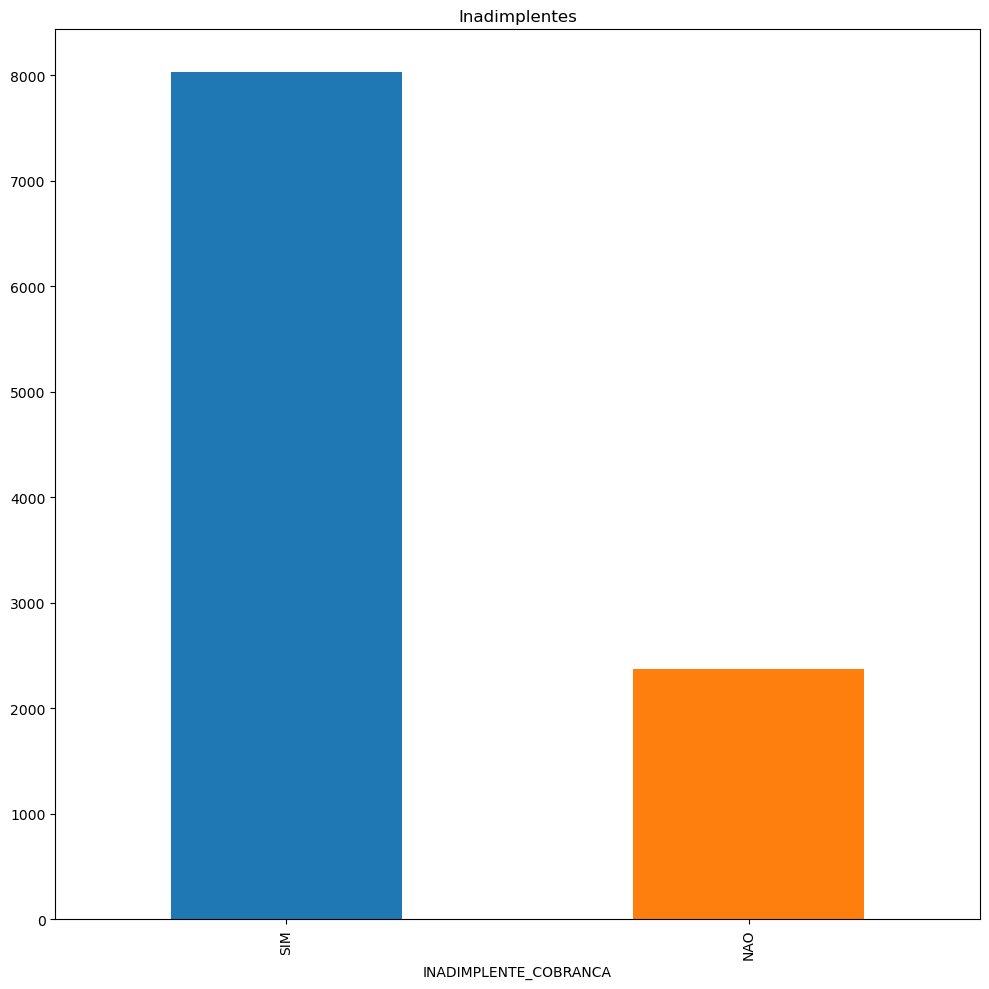

In [143]:
df_dados.INADIMPLENTE_COBRANCA.value_counts().plot(kind='bar', title='Inadimplentes',color = ['#1F77B4', '#FF7F0E']);

Aqui podemos observar que há muito mais instâncias de INADIMPLENTE. Dessa forma, precisaremos balancear o dataset mais adiante.


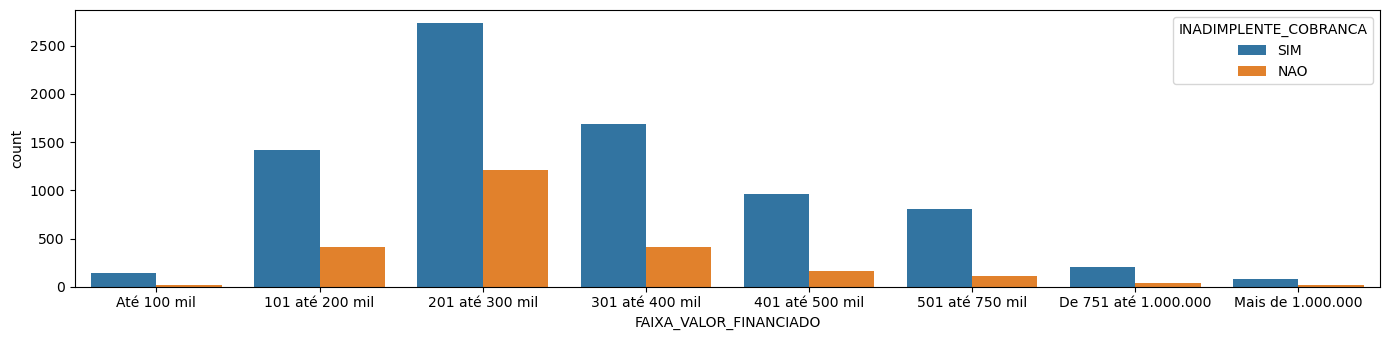

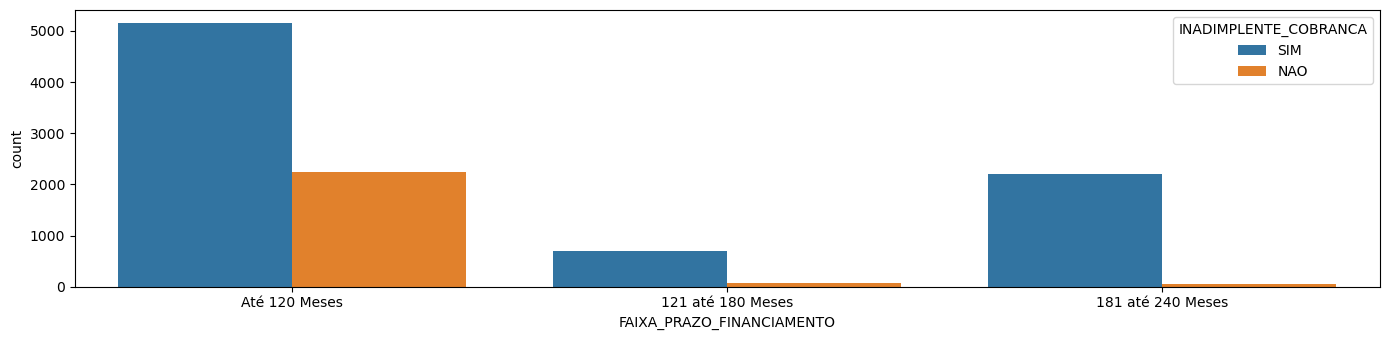

In [144]:
# Ajustando o tamanho da figura globalmente para os gráficos
plt.rcParams["figure.figsize"] = [14.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# Analisando a relação entre 'FAIXA_VALOR_FINANCIADO' e 'INADIMPLENTE_COBRANCA'
sns.countplot(data=df_dados, x="FAIXA_VALOR_FINANCIADO", hue="INADIMPLENTE_COBRANCA")
plt.show()

# Analisando a relação entre 'FAIXA_PRAZO_FINANCIAMENTO' e 'INADIMPLENTE_COBRANCA'
sns.countplot(data=df_dados, x="FAIXA_PRAZO_FINANCIAMENTO", hue="INADIMPLENTE_COBRANCA")
plt.show()


Não há discrepancias nestas variáveis

<span style="font-size: 18px;">Parte 3.3 - Análise Exploratória das Variáveis Categóricas - Tratamento Especial.</span>

Nesta fase, temos dois objetivos principais:

<b>1.</b> Conhecer as Variáveis: Compreender as características de cada variável do conjunto de dados, incluindo sua natureza e distribuição.

<b>2.</b> Análise Estatística para Futuros Tratamentos: Realizar uma análise estatística das variáveis, avaliando métricas como média, mediana, moda, desvio padrão, correlações, outliers e distribuição dos dados. Essa análise ajudará a identificar possíveis tratamentos necessários para preparar os dados para as etapas seguintes.

In [145]:
#carregar variaveis para plot
# Selecionando as variáveis numéricas automaticamente
variaveis_numericas = df_dados.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Visualizando as variáveis numéricas
variaveis_numericas

['TAXA_AO_ANO',
 'RENDA_MENSAL_CLIENTE',
 'QT_PC_ATRASO',
 'QT_DIAS_PRIM_PC_ATRASO',
 'QT_TOTAL_PC_PAGAS',
 'VL_TOTAL_PC_PAGAS',
 'QT_PC_PAGA_EM_DIA',
 'QT_DIAS_MIN_ATRASO',
 'QT_DIAS_MAX_ATRASO',
 'QT_DIAS_MEDIA_ATRASO',
 'VALOR_PARCELA',
 'IDADE_DATA_ASSINATURA_CONTRATO']

Fazendo essa modificação no código, não há necessidade do loop for.

In [100]:
#Quantidade de variaveis
len(variaveis_numericas)

12

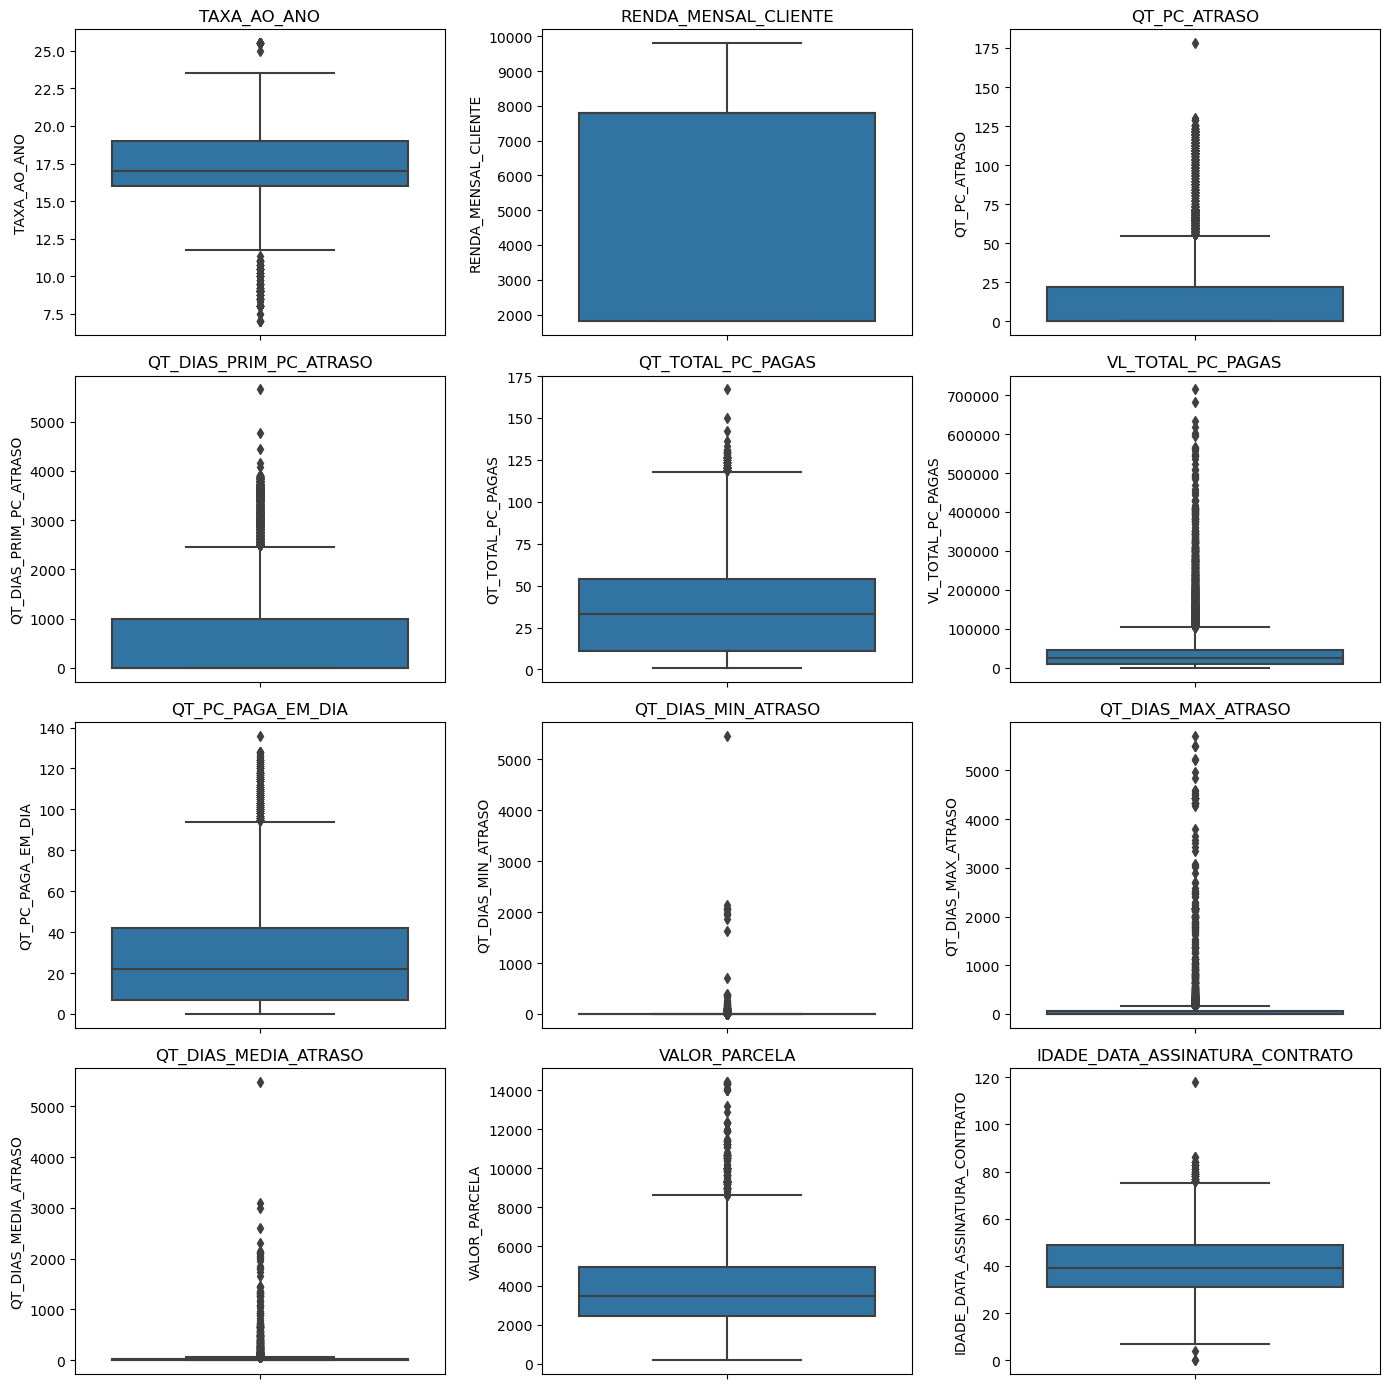

In [147]:
# Visualizando os boxplots das variáveis numéricas
plt.rcParams["figure.figsize"] = [14.00, 14.00]
f, axes = plt.subplots(4, 3)  # 4 linhas e 3 colunas

linha, coluna = 0, 0
for i in variaveis_numericas:
    sns.boxplot(data=df_dados, y=i, ax=axes[linha][coluna])
    axes[linha][coluna].set_title(i)  # Adicionando título para cada gráfico
    coluna += 1
    if coluna == 3:
        linha += 1
        coluna = 0

plt.show()

Nos boxplots, podemos observar que as variáveis numéricas apresentam uma grande quantidade de valores fora do padrão esperado, os chamados 'outliers'. No entanto, dado o contexto específico de análise, que envolve perfis bancários e inadimplência, é importante entender que esses valores podem não ser outliers no sentido clássico. Cada cliente possui um perfil único no banco, e as características financeiras, como renda, valor financiado, e histórico de pagamento, podem variar consideravelmente. Portanto, embora esses valores se distanciem das médias e medianas, eles podem refletir comportamentos financeiros legítimos e significativos, que são cruciais para entender o risco de inadimplência. Por isso, antes de decidir tratar esses valores como outliers, é necessário avaliá-los no contexto dos dados, considerando que, no perfil bancário, tais valores podem representar casos legítimos e informativos.

In [102]:
# carregar variaveis categoricas para OneHotEncoding
# Colocamos o SLICE até 16 porque NÃO precisamos fazer OneHotEncoding para variavel TARGET
variaveis_categoricas = []
for i in df_dados.columns[0:16].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i)   

In [103]:
# Visualizando as variaveis categoricas
variaveis_categoricas

['CIDADE_CLIENTE',
 'ESTADO_CLIENTE',
 'FAIXA_VALOR_FINANCIADO',
 'FAIXA_PRAZO_FINANCIAMENTO']

In [148]:
# Aplicando LabelEncoder para as variáveis categóricas
df_dados[variaveis_categoricas] = df_dados[variaveis_categoricas].apply(lambda col: lb.fit_transform(col))

In [149]:
df_dados.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO,FAIXA_PRAZO_FINANCIAMENTO,INADIMPLENTE_COBRANCA
0,15.0,152,5,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,5,0,SIM
1,15.0,453,25,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,2,1,SIM
2,18.0,453,25,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,4,1,SIM
3,15.0,453,25,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,3,1,SIM
4,17.0,453,25,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,4,1,SIM


In [106]:
# Visualizando os tipos das variaveis
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TAXA_AO_ANO                     10410 non-null  float64
 1   CIDADE_CLIENTE                  10410 non-null  int32  
 2   ESTADO_CLIENTE                  10410 non-null  int32  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64
 4   QT_PC_ATRASO                    10410 non-null  int64  
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64  
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64  
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64  
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64  
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64  
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64  
 12  VALOR_PARCELA                   10410

In [107]:
# Visualiznado a quantidade da variavel target para balanceamento
variavel_target = df_dados.INADIMPLENTE_COBRANCA.value_counts()
variavel_target

INADIMPLENTE_COBRANCA
SIM    8035
NAO    2375
Name: count, dtype: int64

Vamos balancear esses dados, pois, não queremos apresentar para o modelo um valor muito maior(8035) de um tipo do que de outro (2375). Fazemos isso para o aprendizado do modelo não ser tendencioso. Pra isso vamos utilizar o <i><b>SMOTE</b></i>

In [108]:
#Separar variaveis preditoras e target
PREDITORAS = df_dados.iloc[:, 0:15]  
TARGET = df_dados.iloc[:, 16] 

In [109]:
# Visualizando as variaveis preditoras
PREDITORAS.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO
0,15.0,152,5,4800.0,0,0,97,120078.00,72,3,506,152,471.29,70.0,5
1,15.0,453,25,6800.0,0,0,103,156759.47,42,1,349,93,1858.69,28.0,2
2,18.0,453,25,6800.0,0,0,98,277125.05,83,1,151,39,3123.57,60.0,4
3,15.0,453,25,6800.0,0,0,87,351395.19,66,1,3797,206,2873.58,41.0,3
4,17.0,453,25,6800.0,0,0,71,344249.83,57,1,36,10,4224.03,63.0,4


In [110]:
# Visualizando a variavel target
TARGET.head()

0    SIM
1    SIM
2    SIM
3    SIM
4    SIM
Name: INADIMPLENTE_COBRANCA, dtype: object

In [150]:
# Balanceamento dos dados utilizando SMOTE para evitar que o modelo aprenda de forma tendenciosa
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

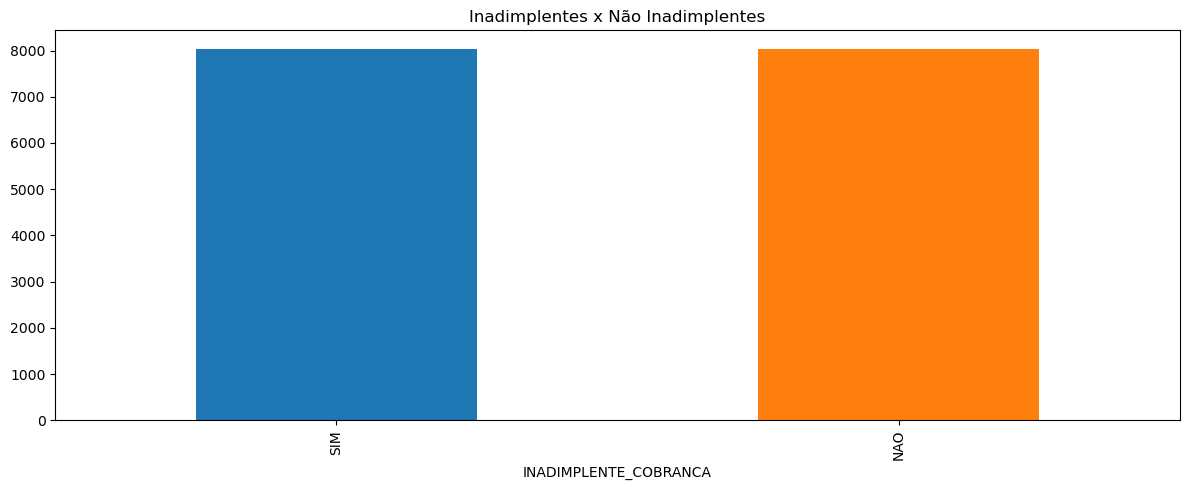

In [112]:
# Visualizando o balanceamento da variável TARGET
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Inadimplentes x Não Inadimplentes',color = ['#1F77B4', '#FF7F0E']);

In [113]:
# Quantidade de registros antes do balanceamento
PREDITORAS.shape

(10410, 15)

In [114]:
# Quantidade de registros antes do balanceamento
TARGET.shape

(10410,)

In [115]:
# Quantidade de registros após do balanceamento
PREDITORAS_RES.shape

(16070, 15)

In [116]:
# Quantidade de registros após do balanceamento
TARGET_RES.shape

(16070,)

# Parte 4 - Machine Learning

<span style="font-size: 18px;">Parte 4.1 - Treinamento dos dados.</span>

O processo começa com a separação dos dados em conjuntos de treinamento e teste, garantindo que o modelo seja avaliado de forma justa. Em seguida, realizamos a normalização dos dados para garantir que todas as variáveis tenham a mesma escala. Com os dados preparados, construímos e treinamos o modelo, ajustando seus parâmetros para otimizar o desempenho. Por fim, avaliamos as métricas de performance e analisamos as variáveis mais importantes para entender o impacto de cada uma no resultado do modelo.

In [117]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)

In [118]:
# Normalizando as Variáveis - Pré Processamento dos Dados - Normalizar é deixar os dados que vão numa escala de 0 a 1.
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

Normalizando, pois, vão deixar os dados que seriam possivelmente "outliers" na mesma escala. Fazemos apenas nas variáveis preditoras. Lembre-se, isso é feito, pois nossos dados estavam em escalas bastante distintas entre coluna para coluna. Os modelos trabalham melhor quando recebem dados padronizados ou normalizados.

Normalizando as variáveis com MinMaxScaler para trazer todas as variáveis para a faixa [0, 1]. Isso é importante pois variáveis em escalas diferentes podem influenciar desproporcionalmente o modelo


In [119]:
# visualizando a dimensão dos dados de treino
X_treino_normalizados.shape

(11249, 15)

In [120]:
# visualizando os dados de treino normalizados
X_treino_normalizados

array([[0.45945946, 0.03816794, 0.15384615, ..., 0.50322829, 0.22033898,
        0.57142857],
       [0.66904491, 0.12977099, 0.23076923, ..., 0.40839172, 0.41221454,
        0.42857143],
       [0.59459459, 0.3110687 , 0.30769231, ..., 0.03970892, 0.25423729,
        0.        ],
       ...,
       [0.10810811, 0.3110687 , 0.30769231, ..., 0.16001324, 0.34745763,
        0.        ],
       [0.64864865, 0.86450382, 0.96153846, ..., 0.23265885, 0.44444926,
        0.14285714],
       [0.42432432, 0.10305344, 0.38461538, ..., 0.03852714, 0.3559322 ,
        0.        ]])

In [121]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators  = 300)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

In [122]:
# Verificando a acuracia do modelo com dados de teste
scores = clf.score(X_teste_normalizados,Y_teste)
scores

0.9180667911221738

In [151]:
from sklearn.metrics import classification_report
print(classification_report(Y_teste, clf.predict(X_teste_normalizados)))

              precision    recall  f1-score   support

         NAO       0.92      0.91      0.92      2396
         SIM       0.91      0.92      0.92      2425

    accuracy                           0.92      4821
   macro avg       0.92      0.92      0.92      4821
weighted avg       0.92      0.92      0.92      4821



Olhando as métricas de maneira mais completa.

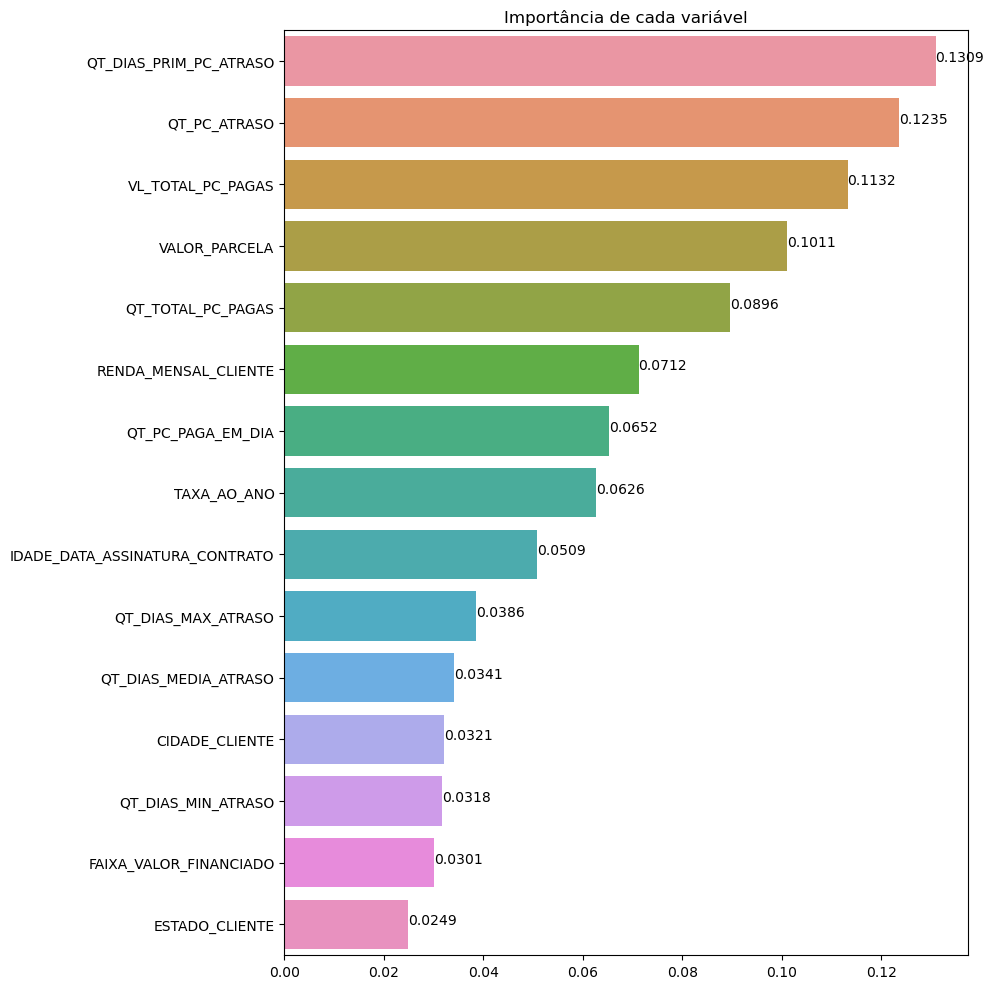

In [152]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
for index, value in enumerate(importances):
    plt.text(value, index, f'{value:.4f}')
plt.show()

In [124]:
importances.sort_values(ascending = False)

QT_DIAS_PRIM_PC_ATRASO            0.130944
QT_PC_ATRASO                      0.123529
VL_TOTAL_PC_PAGAS                 0.113237
VALOR_PARCELA                     0.101119
QT_TOTAL_PC_PAGAS                 0.089592
RENDA_MENSAL_CLIENTE              0.071223
QT_PC_PAGA_EM_DIA                 0.065233
TAXA_AO_ANO                       0.062645
IDADE_DATA_ASSINATURA_CONTRATO    0.050900
QT_DIAS_MAX_ATRASO                0.038590
QT_DIAS_MEDIA_ATRASO              0.034088
CIDADE_CLIENTE                    0.032135
QT_DIAS_MIN_ATRASO                0.031754
FAIXA_VALOR_FINANCIADO            0.030122
ESTADO_CLIENTE                    0.024888
dtype: float64

In [125]:
# Salvando o modelo criado e treinado
joblib.dump(clf, 'modelo_treinado.pk')

['modelo_treinado.pk']

O uso de joblib é recomendado para modelos de Machine Learning, especialmente quando você lida com objetos grandes, pois ele é mais eficiente para objetos numéricos grandes (como os de modelos de aprendizado de máquina).

# Parte 5 - Reestabelecer Conexão com o SQL Server

<i><b>Preparação do código para produção:</b></i> Refatore o código para torná-lo mais eficiente e modular. Adicione documentação clara e detalhada, tanto no código quanto externamente. Escreva testes automatizados para garantir que o sistema funcione corretamente em diferentes cenários.

<i><b>Testar os inputs dos dados no Banco de Dados SQL:</b></i> Valide os dados antes de inseri-los, garantindo que estejam no formato correto e atendam aos requisitos. Trate erros de inserção, como duplicação ou violação de restrições de integridade. Realize testes de consistência, precisão e performance nas operações de leitura e escrita.

In [126]:
# Carregando o modelo treinado
clf = joblib.load('modelo_treinado.pk')

In [127]:
#Importação do arquivo de dados

# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')

# Chama a consulta ao banco de dados passando os parametros da conexão criada
df_original = pd.read_sql_query('select * from EXTRACAO_DADOS_SISTEMA', conexao)

# Fecha conexão com banco de dados
conexao.close()

In [128]:
# Excluindo dados missing
df_original.dropna(inplace=True)


# Criando faixa de prazos para utilizarmos no modelo preditivo
bins = [-100, 120, 180, 240]
labels = ['Até 120 Meses', '121 até 180 Meses', '181 até 240 Meses']
df_original['FAIXA_PRAZO_FINANCIAMENTO'] = pd.cut(df_original['PZ_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_PRAZO_FINANCIAMENTO)


# Criando faixa salarial para utilizarmos no modelo preditivo
bins = [-100, 100000, 200000, 300000, 400000, 500000, 750000, 1000000, 9000000000]
labels = ['Até 100 mil', '101 até 200 mil', '201 até 300 mil', '301 até 400 mil', '401 até 500 mil', 
          '501 até 750 mil', 'De 751 até 1.000.000','Mais de 1.000.000']
df_original['FAIXA_VALOR_FINANCIADO'] = pd.cut(df_original['VALOR_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_VALOR_FINANCIADO)

columns = ['TAXA_AO_ANO', 'CIDADE_CLIENTE', 'ESTADO_CLIENTE','RENDA_MENSAL_CLIENTE', 
           'QT_PC_ATRASO', 'QT_DIAS_PRIM_PC_ATRASO','QT_TOTAL_PC_PAGAS',
           'VL_TOTAL_PC_PAGAS', 'QT_PC_PAGA_EM_DIA','QT_DIAS_MIN_ATRASO',
           'QT_DIAS_MAX_ATRASO', 'QT_DIAS_MEDIA_ATRASO','VALOR_PARCELA',
           'IDADE_DATA_ASSINATURA_CONTRATO', 'FAIXA_VALOR_FINANCIADO',
           'FAIXA_PRAZO_FINANCIAMENTO','INADIMPLENTE_COBRANCA',]

df_dados = pd.DataFrame(df_original, columns=columns)

# carregar variaveis categoricas para OneHotEncoding
variaveis_categoricas = []
for i in df_dados.columns[0:16].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i) 

lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])



# Separar variaveis preditoras
PREDITORAS = df_dados.iloc[:, 0:15]          
    

# Fazendo a normalização dos dados    
Normalizador = MinMaxScaler()
dados_normalizados = Normalizador.fit_transform(PREDITORAS)

previsoes = clf.predict(dados_normalizados)
probabilidades = clf.predict_proba(dados_normalizados)
df_original['PREVISOES'] = previsoes
df_original['PROBABILIDADES'] = probabilidades[:, 1]
df_original.head()

,NUMERO_CONTRATO,DATA_ASSINATURA_CONTRATO,TIPO_FINANCIAMENTO,TAXA_AO_ANO,PZ_FINANCIAMENTO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_FINANCIAMENTO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,INADIMPLENTE_COBRANCA,FAIXA_PRAZO_FINANCIAMENTO,FAIXA_VALOR_FINANCIADO,PREVISOES,PROBABILIDADES
0,41637,2012-03-23,IMOBILIARIO,15.0,180,FORTALEZA,CE,4800.0,0,0,97,120078.00,72,3,506,152,73767.0,471.29,70.0,SIM,121 até 180 Meses,Até 100 mil,SIM,0.970000
1,67958,2012-01-24,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,103,156759.47,42,1,349,93,323251.0,1858.69,28.0,SIM,181 até 240 Meses,301 até 400 mil,SIM,0.956667
2,68502,2014-05-23,IMOBILIARIO,18.0,200,SAO PAULO,SP,6800.0,0,0,98,277125.05,83,1,151,39,529419.0,3123.57,60.0,SIM,181 até 240 Meses,501 até 750 mil,SIM,0.996667
3,68731,2015-10-23,IMOBILIARIO,15.0,200,SAO PAULO,SP,6800.0,0,0,87,351395.19,66,1,3797,206,499753.0,2873.58,41.0,SIM,181 até 240 Meses,401 até 500 mil,SIM,0.863333
4,68996,2017-01-24,IMOBILIARIO,17.0,200,SAO PAULO,SP,6800.0,0,0,71,344249.83,57,1,36,10,722057.0,4224.03,63.0,SIM,181 até 240 Meses,501 até 750 mil,SIM,0.986667


In [129]:
df_original.to_excel('df_original_com_probabilidades.xlsx', index = False)

In [130]:
## Vamos criar nossa tabela intermediaria no SQL e Criar a procedure para fazer o input dos dados

In [131]:
## Inserindo dados no SQL

In [132]:
# Separando as colunas que serão utilizadas para inserção
columns = ['NUMERO_CONTRATO', 'PREVISOES', 'PROBABILIDADES']
df_conversao = pd.DataFrame(df_original, columns=columns)
df_conversao.head()

,NUMERO_CONTRATO,PREVISOES,PROBABILIDADES
0,41637,SIM,0.970000
1,67958,SIM,0.956667
2,68502,SIM,0.996667
3,68731,SIM,0.863333
4,68996,SIM,0.986667


In [133]:
import pymssql as sql
# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')

# Criando um cursor e executando um LOOP no DataFrame para fazer o INSERT no banco SQL Server

cursor = conexao.cursor()

for index,row in df_conversao.iterrows():
    sql = "INSERT INTO RESULTADOS_INTERMEDIARIO (NUMERO_CONTRATO, PREVISOES, PROBABILIDADES) VALUES (%s, %s, %s)"
    val = (row['NUMERO_CONTRATO'],row['PREVISOES'],row['PROBABILIDADES'])    
    cursor.execute(sql, val)
    conexao.commit()
    


print("Dados inseridos com sucesso no SQL")

Dados inseridos com sucesso no SQL


In [134]:
import pymssql as sql
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')
cursor = conexao.cursor()
cursor.execute('EXEC SP_INPUT_RESULTADOS_MODELO_PREDITIVO')    
conexao.commit()
conexao.close()

In [135]:
import pymssql as sql
conexao = sql.connect('localhost', 'usuario_python', '123456', 'MODELOS_PREDITIVOS')
cursor = conexao.cursor()
cursor.execute('TRUNCATE TABLE RESULTADOS_INTERMEDIARIO')
conexao.commit()
conexao.close()